<a href="https://colab.research.google.com/github/rakshasitaram/tflite_flutter_helper/blob/main/plant_identifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- Starting One-Time Preprocessing (Saving to /tmp for speed) ---
--- Preprocessing Complete. 130 images saved to /tmp/masked_training_data/ ---
Found 130 images belonging to 4 classes.
Found 130 images belonging to 4 classes.
Found 19 images belonging to 4 classes.
Found 38 images belonging to 4 classes.
Detected class names: ['Drypetes Variabilis', 'Hieronyma oblonga', 'Manihot Brachyloba ', 'Manihot Esculenta ']
Train samples (Original): 130, Train samples (Masked): 130
Val: 19, Test: 38
Combined generator batch size (per call): 32

--- Starting Phase 1: Feature Extraction ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.3159 - loss: 1.8104 - val_accuracy: 0.3158 - val_loss: 1.6698 - learning_rate: 3.0000e-04
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4543 - loss: 1.3464 - val_accuracy: 0.3684 - val_loss: 1.4079 - learning_rate: 3.0000e-04
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.4575 - loss: 1.2092 - val_accuracy: 0.3684 - val_loss: 1.4179 - learning_rate: 3.0000e-04
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.4921 - loss: 1.1420 - val_accuracy: 0.3158 - val_loss: 1.3781 - learning_rate: 3.0000e-04
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6236 - loss: 0.9839 - val_accuracy: 0.2632 - val_loss: 1.4217 - learning_rate: 3.0000e-04
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6346 - loss: 0.9330 - val_accuracy: 0.2632 - val_loss: 1.4542 - learning_rate: 3.0000e-04
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5700 - loss: 1.0123 - val_

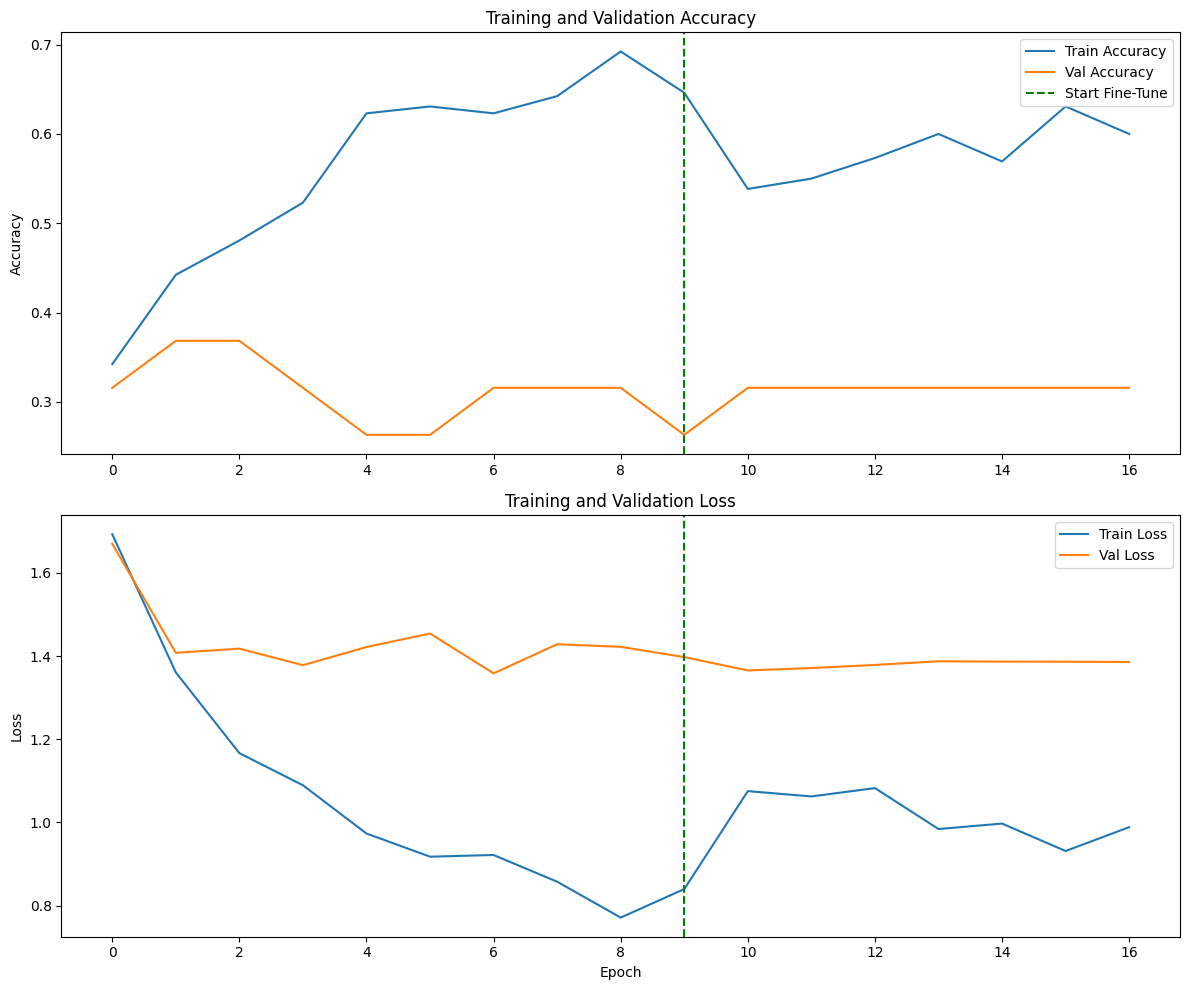

Test loss (Best Model): 1.1216, Test accuracy (Best Model): 0.5000


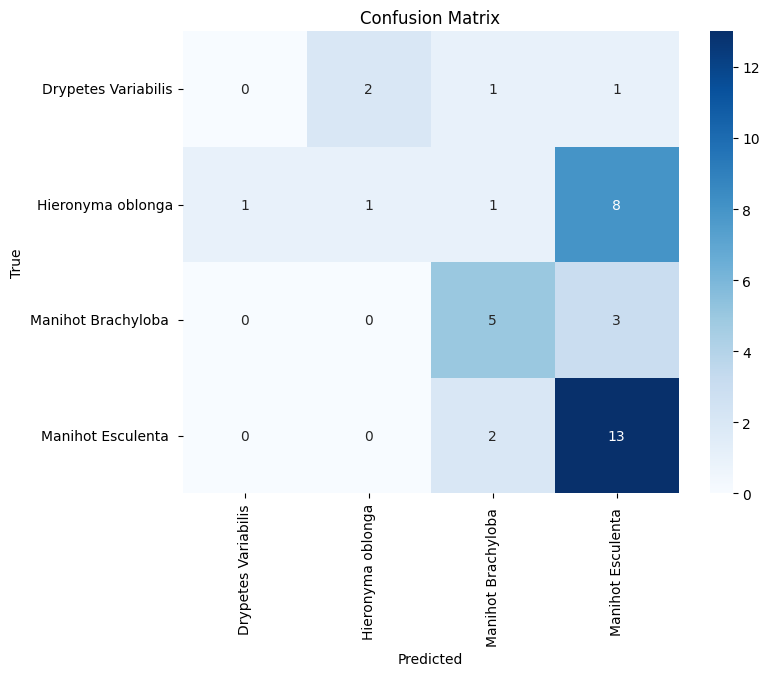


Classification Report:

                     precision    recall  f1-score   support

Drypetes Variabilis     0.0000    0.0000    0.0000         4
  Hieronyma oblonga     0.3333    0.0909    0.1429        11
Manihot Brachyloba      0.5556    0.6250    0.5882         8
 Manihot Esculenta      0.5200    0.8667    0.6500        15

           accuracy                         0.5000        38
          macro avg     0.3522    0.3956    0.3453        38
       weighted avg     0.4187    0.5000    0.4218        38

Saved artifact at '/tmp/tmp6w8fxlrq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  137252884015120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137252884015696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137252884009936: TensorSpec(shape=(), dtype=tf.resource, 

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved TFLite model to: /content/drive/MyDrive/BitBloom/plant_app/plant_identification_model_int8.tflite
Cleaned up temporary masked data directory: /tmp/masked_training_data/


In [5]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import shutil # For cleaning up directories

# ---------------------------
# 1. Setup & Paths
# ---------------------------

# Mount Google Drive
drive.mount('/content/drive')

base_google_drive_path = '/content/drive/MyDrive/BitBloom/plant_app/'

# Input Directories
DATA_DIRS = {
    "train_orig": os.path.join(base_google_drive_path, 'training'),
    "validation": os.path.join(base_google_drive_path, 'validation'),
    "test": os.path.join(base_google_drive_path, 'test')
}

# Temporary directory for pre-processed masked images (use /tmp for fast I/O)
MASKED_TRAIN_DIR = '/tmp/masked_training_data/'

# ---------------------------
# 2. Config
# ---------------------------
NUM_CLASSES = 4
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
BATCH_SIZE_HALF = BATCH_SIZE // 2
EPOCHS_PHASE1 = 10
EPOCHS_PHASE2 = 10
PATIENCE = 6

# ---------------------------
# 3. Preprocessing Logic (Runs Once at Start)
# ---------------------------

def background_removal_single_image(img_path, target_size):
    """Applies HSV-green masking for a single image loaded from disk."""
    try:
        # Load, resize, and convert to BGR (OpenCV default)
        img = cv2.imread(img_path)
        if img is None:
            return None
        img = cv2.resize(img, (target_size[1], target_size[0]))

        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        lower_green = np.array([30, 40, 40])
        upper_green = np.array([90, 255, 255])

        mask = cv2.inRange(img_hsv, lower_green, upper_green)

        # Morphological cleaning
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        # Create a 3-channel mask for bitwise_and
        mask3 = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
        masked_img_bgr = cv2.bitwise_and(img, mask3)

        return masked_img_bgr

    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None

def preprocess_and_save_masked_data(input_dir, output_dir, target_size):
    """Iterates through training data, masks images, and saves them to a temp directory."""
    print("\n--- Starting One-Time Preprocessing (Saving to /tmp for speed) ---")

    # 1. Clean and setup target directory
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir, exist_ok=True)

    total_images = 0

    # Get class directories
    class_dirs = [d for d in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, d))]

    for class_name in class_dirs:
        class_input_path = os.path.join(input_dir, class_name)
        class_output_path = os.path.join(output_dir, class_name)
        os.makedirs(class_output_path, exist_ok=True)

        image_files = [f for f in os.listdir(class_input_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        total_images += len(image_files)

        for i, filename in enumerate(image_files):
            input_path = os.path.join(class_input_path, filename)
            output_path = os.path.join(class_output_path, filename)

            masked_img_bgr = background_removal_single_image(input_path, target_size)

            if masked_img_bgr is not None:
                cv2.imwrite(output_path, masked_img_bgr)

            if (i + 1) % 500 == 0:
                  print(f"  Processed {i+1} images in class {class_name}...")

    print(f"--- Preprocessing Complete. {total_images} images saved to {output_dir} ---")

# Execute the preprocessing step
preprocess_and_save_masked_data(DATA_DIRS["train_orig"], MASKED_TRAIN_DIR, (IMG_HEIGHT, IMG_WIDTH))

# ---------------------------
# 4. Data Generators
# ---------------------------

# Data augmentation settings
AUG_PARAMS = dict(
    rescale=1./255,
    rotation_range=170,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_datagen_orig = ImageDataGenerator(**AUG_PARAMS)
train_datagen_masked = ImageDataGenerator(**AUG_PARAMS) # Same augmentations for masked data

val_test_datagen = ImageDataGenerator(rescale=1./255) # Only scaling for validation/test

# 4a. Original Images Generator
train_generator_orig = train_datagen_orig.flow_from_directory(
    DATA_DIRS["train_orig"],
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE_HALF,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    seed=42
)

# 4b. Pre-processed Masked Images Generator (reads from fast /tmp folder)
train_generator_masked = train_datagen_masked.flow_from_directory(
    MASKED_TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE_HALF,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    seed=42
)

# 4c. Validation and Test Generators (read from Drive, no masking)
validation_generator = val_test_datagen.flow_from_directory(
    DATA_DIRS["validation"],
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    DATA_DIRS["test"],
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

class_names = list(train_generator_orig.class_indices.keys())
print("Detected class names:", class_names)
print(f"Train samples (Original): {train_generator_orig.samples}, Train samples (Masked): {train_generator_masked.samples}")
print(f"Val: {validation_generator.samples}, Test: {test_generator.samples}")

# ---------------------------
# 5. Optimized Combined generator (No OpenCV calls)
# ---------------------------
class CombinedGeneratorOptimized(tf.keras.utils.Sequence):
    """Combines two generators where both are already processed/augmented."""
    def __init__(self, generator_orig, generator_masked):
        self.generator1 = generator_orig
        self.generator2 = generator_masked
        assert generator_orig.batch_size == generator_masked.batch_size, "Batch sizes must match."

    def __len__(self):
        return min(len(self.generator1), len(self.generator2))

    def __getitem__(self, index):
        # Fetch two augmented half-batches
        X1, y1 = self.generator1[index]
        X2, y2 = self.generator2[index]

        # Concatenate and shuffle
        X = np.concatenate([X1, X2], axis=0)
        y = np.concatenate([y1, y2], axis=0)

        idx = np.arange(X.shape[0])
        np.random.shuffle(idx)

        return X[idx], y[idx]

    def on_epoch_end(self):
        self.generator1.on_epoch_end()
        self.generator2.on_epoch_end()

combined_train_generator = CombinedGeneratorOptimized(train_generator_orig, train_generator_masked)
print("Combined generator batch size (per call):", BATCH_SIZE)

# ---------------------------
# 6. Build and Train Model
# ---------------------------

# Build MobileNetV2 Base Model
base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Callbacks
model_checkpoint_path = os.path.join(base_google_drive_path, "best_model.keras")
callbacks = [
    EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint(model_checkpoint_path, save_best_only=True, monitor="val_loss")
]

# Phase 1: Feature Extraction
print("\n--- Starting Phase 1: Feature Extraction ---")
model.compile(optimizer=Adam(learning_rate=3e-4), loss='categorical_crossentropy', metrics=['accuracy'])
history1 = model.fit(
    combined_train_generator,
    epochs=EPOCHS_PHASE1,
    validation_data=validation_generator,
    callbacks=callbacks,
    steps_per_epoch=len(combined_train_generator)
)

# Phase 2: Fine-Tuning
print("\n--- Starting Phase 2: Fine-Tuning ---")
base_model.trainable = True

# Unfreeze last 25% of the base model layers
fine_tune_at = int(len(base_model.layers) * 0.75)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model.fit(
    combined_train_generator,
    epochs=EPOCHS_PHASE1 + EPOCHS_PHASE2,
    initial_epoch=EPOCHS_PHASE1,
    validation_data=validation_generator,
    callbacks=callbacks,
    steps_per_epoch=len(combined_train_generator)
)

# ---------------------------
# 7. Evaluate and Export
# ---------------------------

# Plot training curves
acc = history1.history.get('accuracy', []) + history2.history.get('accuracy', [])
val_acc = history1.history.get('val_accuracy', []) + history2.history.get('val_accuracy', [])
loss = history1.history.get('loss', []) + history2.history.get('loss', [])
val_loss = history1.history.get('val_loss', []) + history2.history.get('val_loss', [])

min_epochs = min(len(acc), len(val_acc), len(loss), len(val_loss))
acc = acc[:min_epochs]
val_acc = val_acc[:min_epochs]
loss = loss[:min_epochs]
val_loss = val_loss[:min_epochs]

plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.axvline(x=EPOCHS_PHASE1 - 1, color='g', linestyle='--', label='Start Fine-Tune')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.axvline(x=EPOCHS_PHASE1 - 1, color='g', linestyle='--')
plt.title('Training and Validation Loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

# Load the best saved model for final evaluation
model = tf.keras.models.load_model(model_checkpoint_path)
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print(f"Test loss (Best Model): {test_loss:.4f}, Test accuracy (Best Model): {test_acc:.4f}")

# Predictions and Confusion Matrix
test_generator.reset()
y_pred_probs = model.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
             xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# TFLite Conversion
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_data_gen():
    """Generator using pre-processed data for TFLite quantization calibration."""
    for i in range(min(50, len(combined_train_generator))):
        X, _ = combined_train_generator[i]
        yield [X.astype(np.float32)]

converter.representative_dataset = representative_data_gen
tflite_model = converter.convert()
tflite_save_path = os.path.join(base_google_drive_path, 'plant_identification_model_int8.tflite')
with open(tflite_save_path, 'wb') as f:
    f.write(tflite_model)
print("Saved TFLite model to:", tflite_save_path)

# Cleanup the temporary directory
shutil.rmtree(MASKED_TRAIN_DIR)
print(f"Cleaned up temporary masked data directory: {MASKED_TRAIN_DIR}")